# Isochrones for a cluster using PopStar

In [21]:
using PyCall

## PopStar modules...
synthetic= pyimport("popstar.synthetic")
evolution= pyimport("popstar.evolution")
atmospheres= pyimport("popstar.atmospheres")
reddening= pyimport("popstar.reddening")

using Distributions
using Statistics
using DataFrames
using Distances
using Random , Printf

rootdir = "/home/stephane/Science/cluster/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

import PyPlot , CSV

wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
ocdir   = "$rootdir/products/oc2"

cd(wdir)

In [22]:
ocfile= "Alessi 5-1.8deg-oc.csv"
df= CSV.read("$ocdir/$ocfile", delim= ";")

agmedian= median(df.ag[.! isnan.(df.ag)])
distance= median(df.distance)

# Define isochrone parameters
logAge = 7.765  # Age in log(years)
AKs = agmedian # extinction in mags
dist = distance # distance in parsec
metallicity = 0 # Metallicity in [M/H]

0

In [23]:
## Define evolution/atmosphere models and extinction law
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

## Filter
filt_list = ["gaia,dr2_rev,G", "gaia,dr2_rev,Gbp","gaia,dr2_rev,Grp"]

iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)

#println(keys(iso))

data= iso.points
println(data.keys())
println(data.Teff)

["L", "Teff", "R", "mass", "logg", "isWR", "mass_current", "phase", "m_hst_G", "m_hst_Gbp", "m_hst_Grp"]


KeyError: KeyError: key "Teff" not found

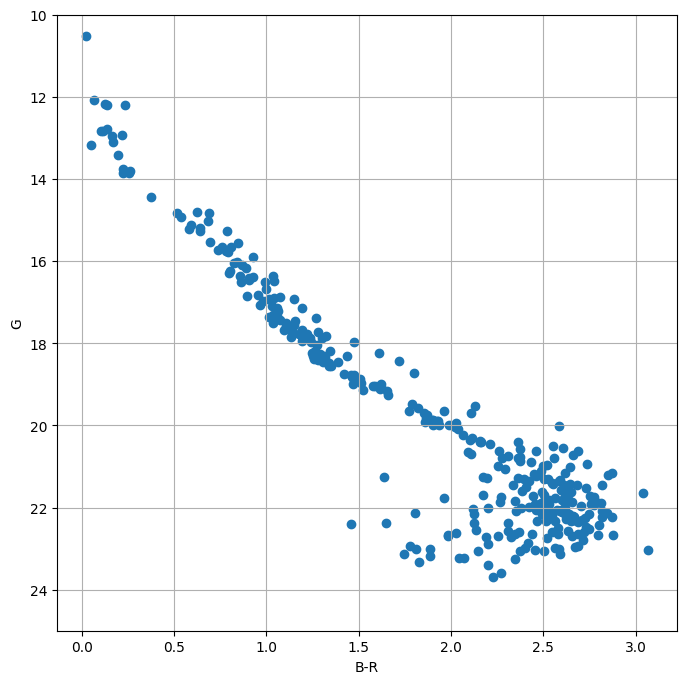

In [24]:
### plots the CMD and isochrones

fig= PyPlot.figure(figsize=(8,8))

ax = PyPlot.subplot(111)
PyPlot.grid("on")

PyPlot.ylim(25,10)
PyPlot.scatter(df.bp .- df.rp , df.gbar)

# PyPlot.plot(iso["points"][:][10] .- iso.points[:][11], iso.points[:][9], "r-")
PyPlot.ylabel("G")
PyPlot.xlabel("B-R")
PyPlot.show()